# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Define Custom Functions

In [2]:
def plot_classes_distribution(data_generator, palette="viridis", title = ""):

    # Extract class labels and class indices
    class_labels = list(data_generator.class_indices.keys())
    class_counts = pd.Series(data_generator.classes).value_counts().sort_index()

    # Create a DataFrame for plotting
    data_counts = pd.DataFrame({'Class': class_labels, 'Count': class_counts.values})

    # Plotting
    plt.figure(figsize=(6, 6))
    sns.barplot(data=data_counts, x='Class', y='Count', palette=palette, hue='Class')
    plt.title(f"{title} Classes Distribution")
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()


def show_images(data_generator, class_names, title):

    plt.figure(figsize=(16, 8))

    # Get a batch of images and labels
    images, labels = next(data_generator)  # Fetch a batch from the generator

    # Display the first 6 images
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i], cmap='gray')

        # Convert label to integer for indexing
        plt.title(class_names[int(labels[i])])  # Map label to class name
        plt.axis('off')

    plt.suptitle(title)
    plt.show()


def preprocess(img):
    img = img.astype(np.uint8)  # Convert to uint8
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

    img = np.expand_dims(img, axis=-1)  # Add channel dimension for compatibility
    return img

### To avoid Truncation Error

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Read Data

### define paths

In [4]:
train_dir = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
val_dir = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'
test_dir = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'

### define generators to read the data

In [5]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
img_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=5,  
    width_shift_range=0.05,  
    height_shift_range=0.05,
    horizontal_flip=True,
    preprocessing_function=preprocess
)


val_datagen = ImageDataGenerator(
    rotation_range=2,  
    width_shift_range=0.02,  
    height_shift_range=0.02,
    preprocessing_function=preprocess
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess
)

In [7]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle = True
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle = True
)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle = False
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [8]:
images, _ = next(train_ds)
print("Min pixel value:", images.min())
print("Max pixel value:", images.max())
print(images.shape)

Min pixel value: 0.0
Max pixel value: 1.0
(32, 224, 224, 1)


# Data Visualization

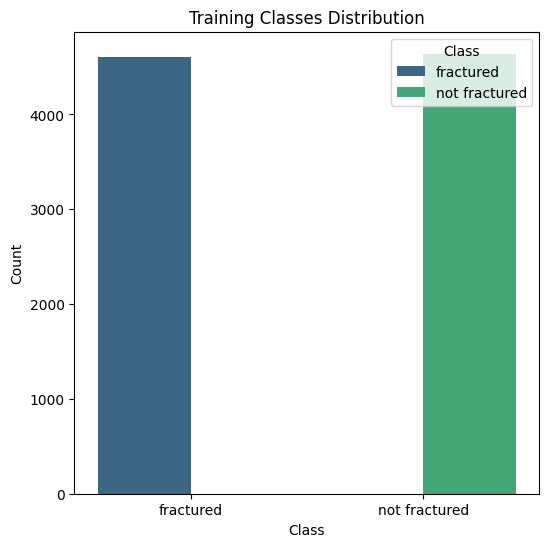

In [9]:
plot_classes_distribution(train_ds, title="Training")

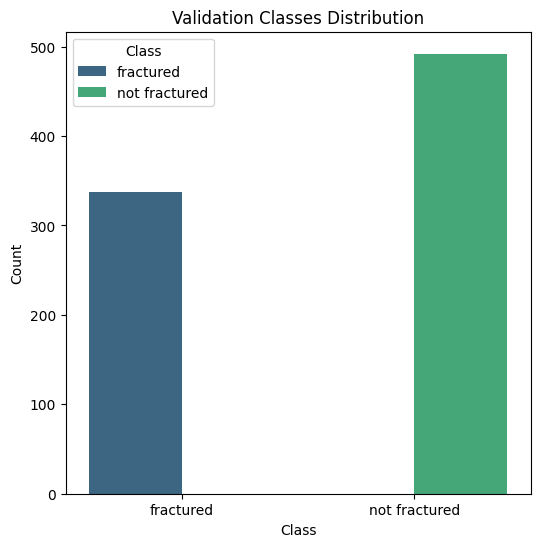

In [10]:
plot_classes_distribution(val_ds, title="Validation")

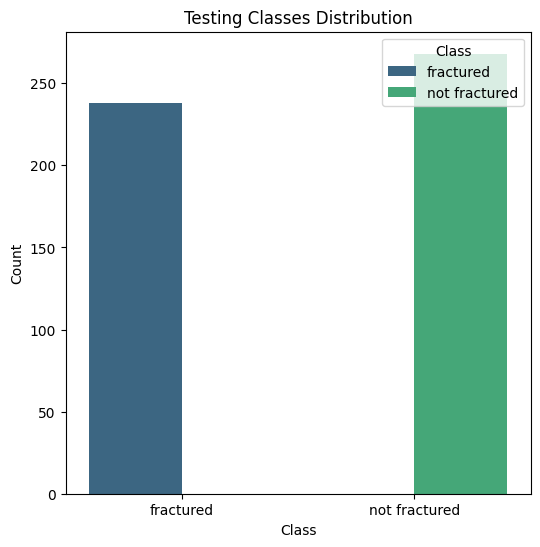

In [11]:
plot_classes_distribution(test_ds, title="Testing")

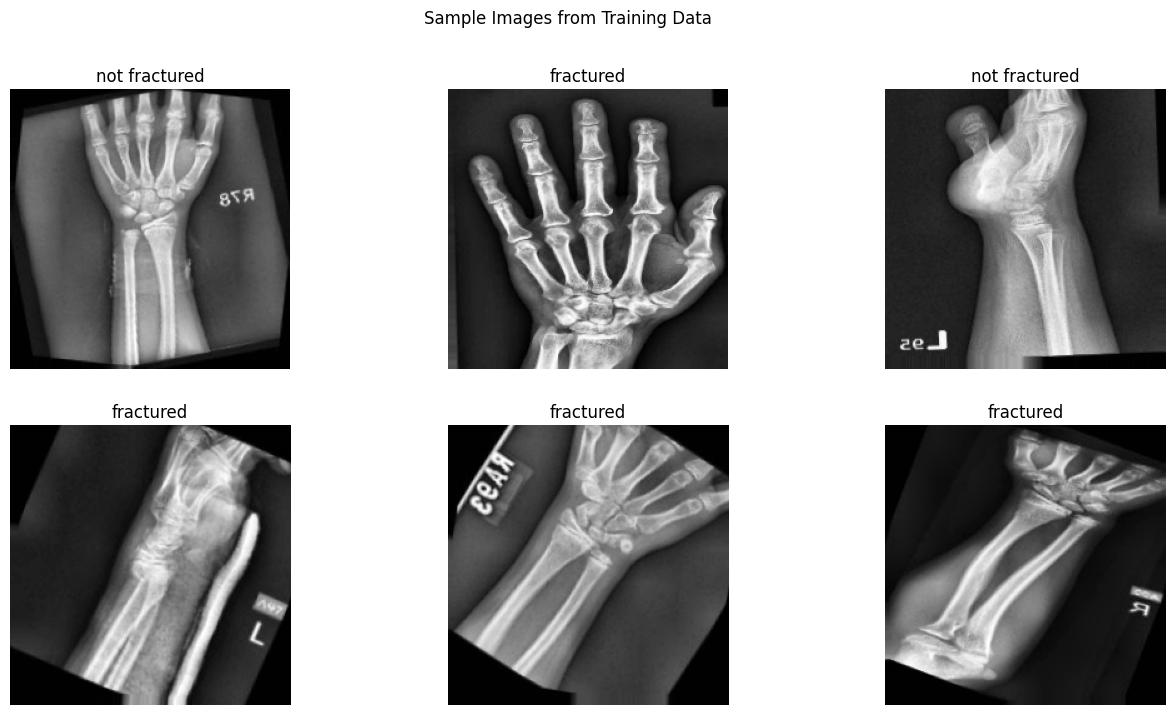

In [12]:
train_class_names = list(train_ds.class_indices.keys())
show_images(train_ds, train_class_names, title='Sample Images from Training Data')

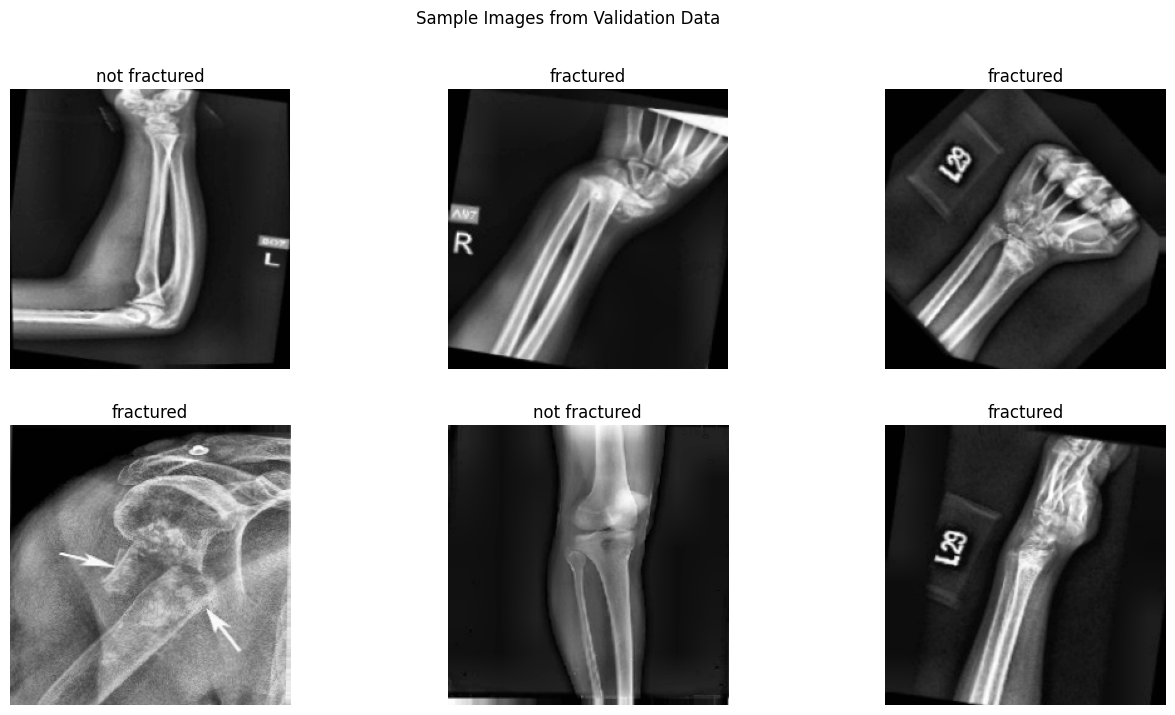

In [13]:
val_class_names = list(val_ds.class_indices.keys())
show_images(val_ds, val_class_names, title='Sample Images from Validation Data')

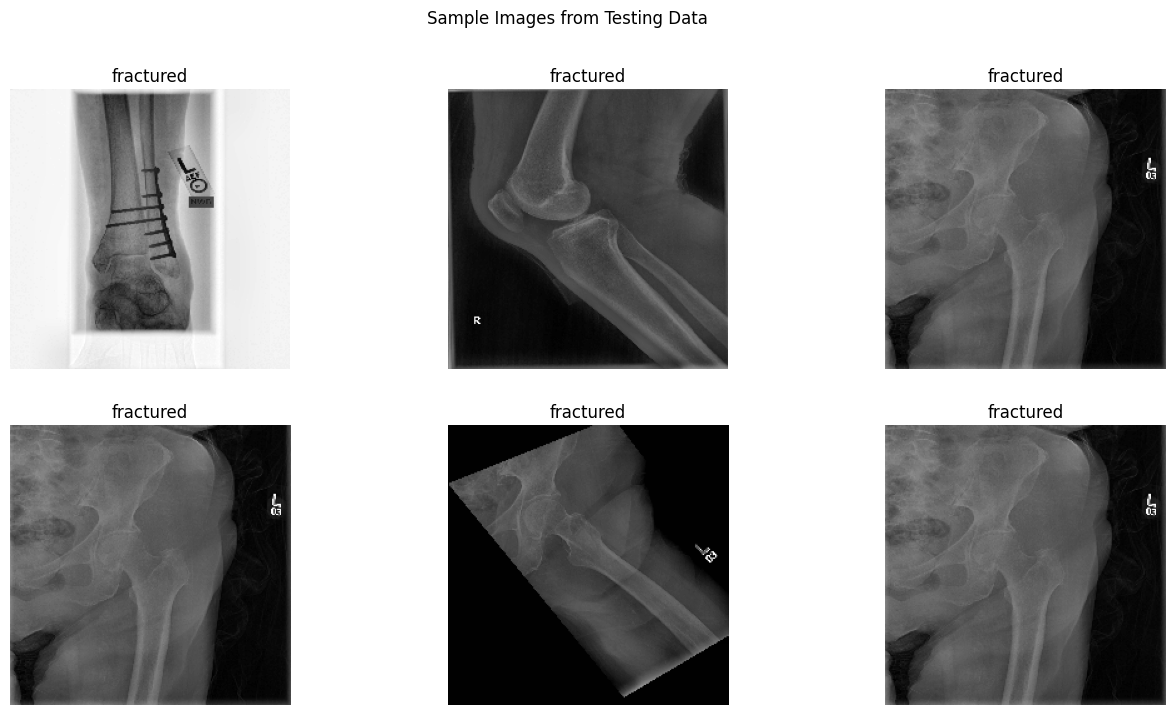

In [14]:
test_class_names = list(test_ds.class_indices.keys())
show_images(test_ds, test_class_names, title='Sample Images from Testing Data')

In [15]:
images, labels = next(iter(train_ds))  # Get the first batch of images and labels
first_image_shape = images[0].shape  # Get the shape of the first image
print(f"Shape of the first image: {first_image_shape}")

Shape of the first image: (224, 224, 1)


# Modeling

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu',
           kernel_initializer='he_normal',
           input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),

    BatchNormalization(),
    
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu',
           kernel_initializer='he_normal'),
    
    Dropout(0.2),

    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu',
           padding='same', strides=1,
           kernel_initializer='he_normal'),

    BatchNormalization(),
    
    MaxPooling2D((3, 3)),

    Flatten(),
    
    Dense(256, activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.01)),  
    
    Dropout(0.3),
    
    Dense(128, activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.01)),  

    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 54, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,743,425 (40.98 MB)

 Trainable params: 10,743,105 (40.98 MB)

 Non-trainable params: 320 (1.25 KB)

In [17]:
optimizer = Adam(learning_rate=0.00009)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30


I0000 00:00:1739987841.979150     127 service.cc:145] XLA service 0x7bac34010760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739987841.979208     127 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1739987841.979214     127 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/289 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.5000 - loss: 9.6005   

I0000 00:00:1739987852.112875     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


289/289 ━━━━━━━━━━━━━━━━━━━━ 131s 402ms/step - accuracy: 0.6471 - loss: 8.4342 - val_accuracy: 0.6068 - val_loss: 8.3958
Epoch 2/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 67s 225ms/step - accuracy: 0.8058 - loss: 6.2356 - val_accuracy: 0.7841 - val_loss: 5.4054
Epoch 3/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 66s 222ms/step - accuracy: 0.8577 - loss: 4.7991 - val_accuracy: 0.8794 - val_loss: 4.0005
Epoch 4/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 66s 225ms/step - accuracy: 0.8803 - loss: 3.6898 - val_accuracy: 0.8890 - val_loss: 3.0878
Epoch 5/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 66s 224ms/step - accuracy: 0.9108 - loss: 2.8287 - val_accuracy: 0.8975 - val_loss: 2.4122
Epoch 6/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 65s 221ms/step - accuracy: 0.9210 - loss: 2.2133 - val_accuracy: 0.9095 - val_loss: 1.9475
Epoch 7/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 65s 220ms/step - accuracy: 0.9286 - loss: 1.7306 - val_accuracy: 0.9095 - val_loss: 1.5276
Epoch 8/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 65s 218ms/step - accuracy: 0.9418 - loss: 1.3835 - va

In [19]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - accuracy: 0.9253 - loss: 0.2854
Test Accuracy: 0.96
Test Loss: 0.22


<Axes: >

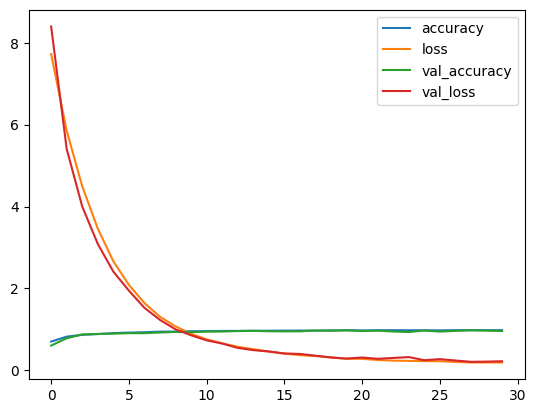

In [20]:
Results=pd.DataFrame(history.history)
Results.plot()

<Axes: >

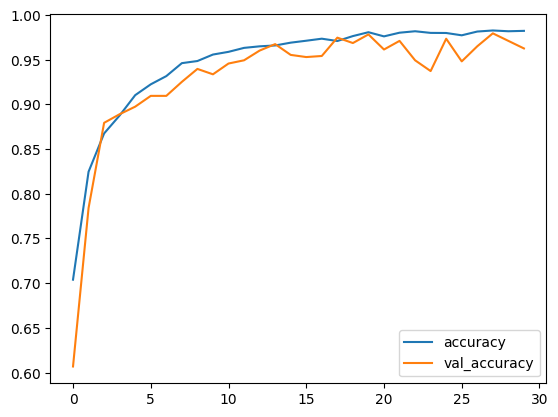

In [21]:
Results[['accuracy','val_accuracy']].plot()

<Axes: >

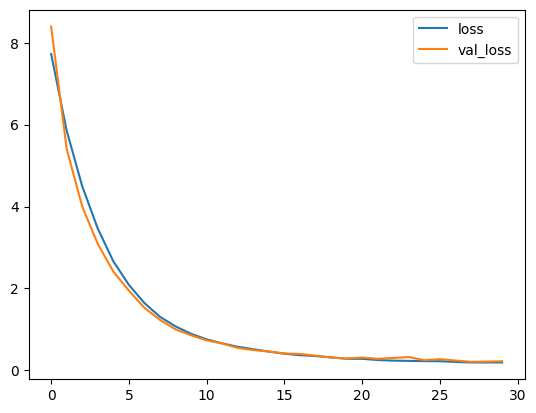

In [22]:
Results[['loss','val_loss']].plot()

In [23]:
predictions = model.predict(test_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step


In [24]:
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels
true_classes = test_ds.classes

report = classification_report(true_classes, predicted_classes, target_names=list(test_ds.class_indices.keys()))
print(report)

               precision    recall  f1-score   support

    fractured       0.99      0.94      0.96       238
not fractured       0.95      0.99      0.97       268

     accuracy                           0.96       506
    macro avg       0.97      0.96      0.96       506
 weighted avg       0.97      0.96      0.96       506



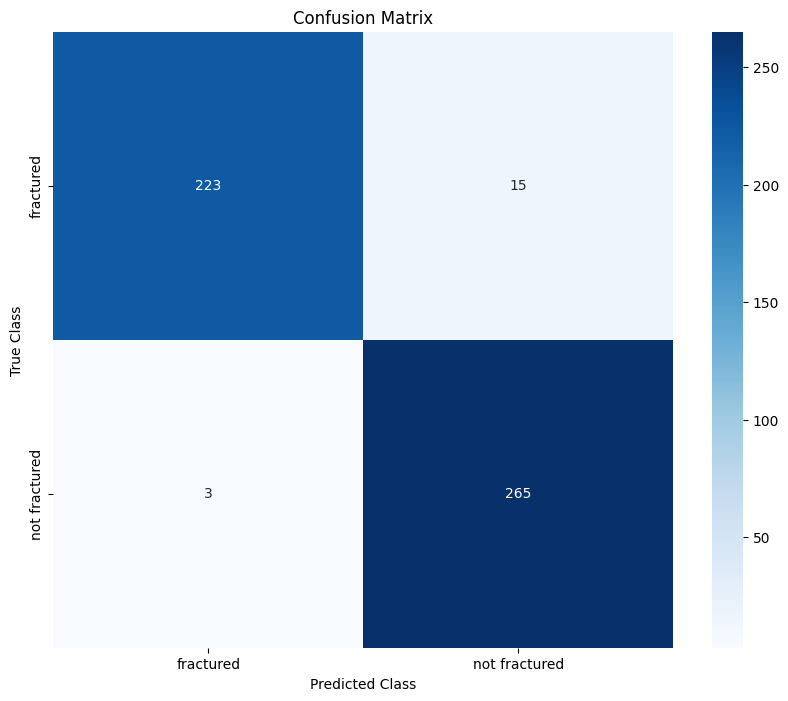

In [25]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_ds.class_indices.keys()), yticklabels=list(test_ds.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [ ]:
model.save('/kaggle/working/BoneX_Final_ModelV4.h5')